## Prepare for Data

In [1]:
class Lang():
    def __init__(self, lang_name):
        self.name = lang_name
        
        self.word2index = {}
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        
        self.word_count = {}
        
        self.n_words = 2
    
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)
    
    def add_word(self, word):
        if word not in self.word_count:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            
            self.word_count[word] = 1
            
            self.n_words += 1
        else:
            self.word_count[word] += 1

In [2]:
import unicodedata

def unicode_2_ascii(sentence):
    ascii_str = ''
    
    for char in unicodedata.normalize("NFD", sentence):
        if unicodedata.category(char) != "Mn":
            ascii_str += char
            
    return ascii_str

In [3]:
import re

def normalize_string(sentence):
    # Lowercase.
    sentence = sentence.lower()
    # Unicode -> ascii.
    sentence = unicode_2_ascii(sentence)
    # Adds a space between chrs and [.!?].
    sentence = re.sub(r"([.!?])", r" \1", sentence)  # r''
    # Keeps only letters and [.!?].
    sentence = re.sub(r"[^a-zA-Z.!?]+", r" ", sentence)
    
    return sentence

In [4]:
def read_pairs(file):
    with open(file, encoding="utf-8") as f:
        file_data = f.read()
        
    # Puts lines in a list.
    lines = file_data.strip().split('\n')
    # Splits into pairs.
    pairs = [line.split('\t') for line in lines]
    # Strips sentences.
    pairs = [[sentence.strip() for sentence in pair] for pair in pairs]  # two []s
    # Normalizes sentences.
    pairs = [[normalize_string(sentence) for sentence in pair] for pair in pairs]
    
    return pairs

In [5]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_(pairs, max_len):
    return [pair for pair in pairs if len(pair[0].split(' ')) < max_len 
            and len(pair[1].split(' ')) < max_len
            and pair[0].startswith(eng_prefixes)]

In [6]:
def prepare_data(lang1, lang2, reverse=False, max_len=10):
    print("preparing data...")
    
    # Generates the file name.
    file = f"data/{lang1}-{lang2}.txt"
    # Reads sentence pairs from file.
    pairs = read_pairs(file)
    # Filters with max len.
    pairs = filter_(pairs, max_len)
    
    # Creates Lang objs.
    if reverse:
        pairs = [list(reversed(pair)) for pair in pairs]
        
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    for input_sentence, output_sentence in pairs:
        input_lang.add_sentence(input_sentence)
        output_lang.add_sentence(output_sentence)
    
    print(f"input lang: {input_lang.name}")
    print(f"words in input lang: {input_lang.n_words}")
    print()
    print(f"output lang: {output_lang.name}")
    print(f"words in output lang: {output_lang.n_words}")
    print()
    
    return input_lang, output_lang, pairs

## Model

### Encoder

In [7]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, embed_size):
        super(Encoder, self).__init__()
        
        # Params.
        self.hidden_size = hidden_size
        
        # Embedding.
        self.embedding = nn.Embedding(input_size, embed_size)
        
        # GRU.
        self.gru = nn.GRU(embed_size, hidden_size)
    
    def forward(self, input_, hidden):
        embed = self.embedding(input_)
        
        embed = embed.view(1, 1, -1)
        output, hidden = self.gru(embed, hidden)
        
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)  # device

### Decoder

In [8]:
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, embed_size, dropout_p=0.1):
        super(Decoder, self).__init__()
        
        # Embedding.
        self.embedding = nn.Embedding(output_size, embed_size)
        self.dropout = nn.Dropout(dropout_p)
        
        # Attn.
        self.attn = Attention(hidden_size)  # receives the size of a context vector
        
        # GRU.
        self.gru = nn.GRU(embed_size + hidden_size, hidden_size)
        
        # Linear.
        self.out = nn.Linear(hidden_size + hidden_size, output_size)
#         self.out = nn.Linear(embed_size + hidden_size + hidden_size, output_size)
        
    def forward(self, last_output, last_hidden, encoder_outputs):
        embed = self.embedding(last_output)
        embed = self.dropout(embed)
        
        # Calculates attention weights.
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        # Calcualtes the context vector whose size is [1, hidden_size]
        context = attn_weights.mm(encoder_outputs)

        # Combines embedded word and attended context.
        embed = embed.view(1, 1, -1)
        context = context.view(1, 1, -1)
        rnn_input = torch.cat((embed, context), 2)
        
        # s_i = f(c_i, y_{i - 1}, s_{i - 1})
        output, hidden = self.gru(rnn_input, last_hidden)  
        
        # \hat y_{i} = g(c_i, y_{i - 1}, s_i)
        output = self.out(torch.cat((output, context), 2)).view(1, -1)
#         output = self.out(torch.cat((output, rnn_input), 2)).view(1, -1)
        output = F.log_softmax(output, dim=1)

        return output, hidden, attn_weights

In [9]:
# import torch.nn.functional as F

# # closer to a lesser-used "location-based" strategy from Luong et al
# class Decoder(nn.Module):
#     def __init__(self, output_size, hidden_size, embed_size, dropout_p=0.1, max_length=10):
#         super(Decoder, self).__init__()
        
#         self.hidden_size = hidden_size
#         self.embed_size = embed_size
#         self.output_size = output_size
#         self.dropout_p = dropout_p
#         self.max_length = max_length

#         self.embedding = nn.Embedding(self.output_size, self.hidden_size)
#         self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
#         self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
#         self.dropout = nn.Dropout(self.dropout_p)
#         self.gru = nn.GRU(self.hidden_size, self.hidden_size)
#         self.out = nn.Linear(self.hidden_size, self.output_size)

#     def forward(self, input, hidden, encoder_outputs):
#         embedded = self.embedding(input).view(1, 1, -1)
#         embedded = self.dropout(embedded)

#         attn_weights = F.softmax(
#             self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
#         attn_applied = torch.bmm(attn_weights.unsqueeze(0),
#                                  encoder_outputs.unsqueeze(0))

#         output = torch.cat((embedded[0], attn_applied[0]), 1)
#         output = self.attn_combine(output).unsqueeze(0)

#         output = F.relu(output)
#         output, hidden = self.gru(output, hidden)

#         output = F.log_softmax(self.out(output[0]), dim=1)
#         return output, hidden, attn_weights

#     def initHidden(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

### Attention

In [10]:
# class Attention(nn.Module):
#     def __init__(self, hidden_size):
#         super(Attention, self).__init__()
                
#         # Concat.
#         self.attn = nn.Linear(hidden_size * 2, hidden_size)
#         self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

        
#     def forward(self, hidden, encoder_outputs):        
#         # Params.
#         seq_len = len(encoder_outputs)
        
#         attn_energies = torch.zeros(seq_len, device=device)  # device
        
#         # Calculates energies.
#         for i in range(seq_len):
#             attn_energies[i] = self.score(hidden, encoder_outputs[i])
            
#         # Normalizes energies.
#         attn_energies = F.softmax(attn_energies)
        
#         # Squeezes.
#         attn_energies = attn_energies.unsqueeze(0).unsqueeze(0)
        
#         return attn_energies
    
#     def score(self, hidden, encoder_output):
#         energy = self.attn(torch.cat((hidden, encoder_output), 1))
# #         print(self.v.size(), energy.size())
#         energy = self.v.dot(energy)
        
#         return energy

In [11]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
#         self.v = nn.Parameter(torch.FloatTensor(hidden_size))
        self.v = nn.Parameter(torch.empty(hidden_size, dtype=torch.float, device=device))

    def concat_score(self, hidden, encoder_output):
        hidden = hidden.expand(encoder_output.size(0), -1)
        
#         max_len * (hidden_size * 2) -> max_len * hidden_size
        energy = self.attn(torch.cat((hidden, encoder_output), 1)).tanh()
        
        # Dot operation.
        return torch.sum(self.v * energy, dim=1).view(1, -1)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        attn_energies = self.concat_score(hidden, encoder_outputs)

#         # Transpose max_length and batch_size dimensions
#         attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1)

## Traning

In [12]:
def sentence_2_indexes(sentence, lang):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [13]:
def sentence_2_tensor(sentence, lang):
    indexes = sentence_2_indexes(sentence, lang)
    indexes.append(EOS_token)
    
    return torch.tensor(indexes, dtype=torch.long, 
                        device=device).unsqueeze(-1)  # dtype, device

In [14]:
import random

def random_example(pairs, input_lang, output_lang):
    pair = random.choice(pairs)
    
    input_sentence, target_sentence = pair
    
    input_tensor = sentence_2_tensor(input_sentence, input_lang)
    target_tensor = sentence_2_tensor(target_sentence, output_lang)
    
    return input_tensor, target_tensor

In [15]:
def time_format(total_secs):
    minutes = int(total_secs / 60)
    seconds = total_secs - minutes * 60
    
    return f"{minutes:>2.0f}m {seconds:>2.0f}s"

In [16]:
def time_track(start, train_percent):
    now = time.time()
    
    spent_secs = now - start
    entire_secs = spent_secs / train_percent
    remaining_secs = entire_secs - spent_secs
    
    return f"{time_format(spent_secs)} (-{time_format(remaining_secs)})"

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_losses(losses_plot):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.2))
    
    plt.plot(losses_plot)
    plt.show()

In [18]:
def train_(input_, target, encoder, decoder, loss_function, encoder_optimizer, decoder_optimizer, teacher_forcing_ratio, max_len):
    # Sees if the decoder is trained with teacher forcing.
    teacher_forcing = True if random.random() > teacher_forcing_ratio else False
    
    # Params.
    input_len = len(input_)
    target_len = len(target)
    
    loss = 0
    
    # Encoder.
    encoder_outputs = torch.zeros(max_len, encoder.hidden_size, device=device)  # device
    
    # Inits hidden.
    encoder_hidden = encoder.init_hidden()
    
    # Zeros grad.
    encoder_optimizer.zero_grad()  # optim.zerograd(), not model.zero_grad()
    
    for i in range(input_len):
        encoder_output, encoder_hidden = encoder(input_[i], encoder_hidden)
        
        encoder_outputs[i] = encoder_output[0][0]  # [0][0]
        
    # Decoder.
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    # Inits hidden.
    decoder_hidden = encoder_hidden
    
    # Zeros grad.
    decoder_optimizer.zero_grad()  # optim.zerograd(), not model.zero_grad()
    
    if teacher_forcing:
        for i in range(target_len):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # Calculates the loss.
            loss += loss_function(decoder_output, target[i])  # +=
            
            decoder_input = target[i]
    else:
        for i in range(target_len):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # Calculates the loss.
            loss += loss_function(decoder_output, target[i])  # +=
            
            top_value, top_index = decoder_output.topk(1)
            
            decoder_input = top_index  # detach?
            
            if decoder_input.item() == EOS_token:
                break
                
    # Backward.
    loss.backward()
    
    # Updates params.
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_len

In [19]:
import time
import torch.optim as optim

def train(encoder, decoder, pairs, input_lang, output_lang, n_iters=75_000, learning_rate=0.01, teacher_forcing_ratio=0.5, 
          display_every=5_000, plot_every=500, max_len=10):
    
    print("Training...")
    
    # Params for tracking the training process.
    loss_display = 0
    loss_plot = 0
    losses_plot = []
    
    start = time.time()
    
    # Loss function.
    loss_function = nn.NLLLoss()
    
    # Optimizers.
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    # Training.
    for iteration in range(1, n_iters + 1):
        # Gets an example.
        input_, target = random_example(pairs, input_lang, output_lang)

        # Trains with the example.
        loss = train_(input_, target, encoder, decoder, loss_function, encoder_optimizer, decoder_optimizer, teacher_forcing_ratio, 
                      max_len)
        
        # Tracks the training process.
        loss_display += loss
        if iteration % display_every == 0:
            avg_loss_display = loss_display / display_every
            train_percent = iteration / n_iters
            print(f"iteration: {iteration:>6} {train_percent:>2.0%} {time_track(start, train_percent)} loss: {avg_loss_display:.6f}")
            loss_display = 0
            
        loss_plot += loss
        if iteration % plot_every == 0:
            avg_loss_plot = loss_plot / plot_every
            losses_plot.append(avg_loss_plot)
            loss_plot = 0
            
    plot_losses(losses_plot)

## Evaluating

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attentions, input_sentence, outputs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    color_ax = ax.matshow(attentions)
    fig.colorbar(color_ax)
    
    ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + outputs)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

In [21]:
def evaluate_(input_, encoder, decoder, target_lang, max_len):
    with torch.no_grad():  # grad not needed
        # Params.
        input_len = len(input_)
        
        outputs = []
        attentions = torch.zeros(max_len, max_len)  # not needed to be in cuda

        # Encoder.
        encoder_outputs = torch.zeros(max_len, encoder.hidden_size, device=device)

        # Init hidden.
        encoder_hidden = encoder.init_hidden()

        for i in range(input_len):
            encoder_output, encoder_hidden = encoder(input_[i], encoder_hidden)

            encoder_outputs[i] = encoder_output[0][0]

        # Decoder.
        decoder_input = torch.tensor([[SOS_token]], device=device)
    
        # Init hidden.
        decoder_hidden = encoder_hidden
    
        for i in range(max_len):
            decoder_output, decoder_hidden, attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            top_value, top_index = decoder_output.topk(1)
            decoder_input = top_index
            
            attentions[i] = attention
            if top_index.item() == EOS_token:
                outputs.append('<EOS>')
                break
            else:
                outputs.append(target_lang.index2word[top_index.item()])
                
        return outputs, attentions

In [22]:
def evaluate(encoder, decoder, pairs, input_lang, target_lang, n_evals=5, max_len=10):
    for evaluation in range(1, n_evals + 1):
        # Gets an example.
        input_, target = random_example(pairs, input_lang, target_lang)
        
        # Evaluates with the example.
        outputs, attentions = evaluate_(input_, encoder, decoder, target_lang, max_len)
        input_sentence = " ".join([input_lang.index2word[idx.data.item()] for idx in input_])
        target_sentence = " ".join([target_lang.index2word[idx.data.item()] for idx in target])
        
        # Displays the results.
        print("input: ", input_sentence)
        print("target:", target_sentence)
        print("output:", " ".join(outputs))
        
        # Plots attention.
        plot_attention(attentions, input_sentence, outputs)

## Main

preparing data...
input lang: eng
words in input lang: 2803

output lang: fra
words in output lang: 4345

Training...
iteration:   5000 7%  2m 54s (-40m 34s) loss: 3.142394
iteration:  10000 13%  5m 57s (-38m 41s) loss: 2.416975
iteration:  15000 20%  9m  4s (-36m 16s) loss: 2.032732
iteration:  20000 27% 12m 12s (-33m 34s) loss: 1.726594
iteration:  25000 33% 15m 18s (-30m 35s) loss: 1.534338
iteration:  30000 40% 18m 21s (-27m 32s) loss: 1.358378
iteration:  35000 47% 21m 28s (-24m 32s) loss: 1.203194
iteration:  40000 53% 24m 38s (-21m 33s) loss: 1.103568
iteration:  45000 60% 27m 41s (-18m 27s) loss: 0.975269
iteration:  50000 67% 30m 46s (-15m 23s) loss: 0.934426
iteration:  55000 73% 33m 49s (-12m 18s) loss: 0.855136
iteration:  60000 80% 36m 55s (- 9m 14s) loss: 0.765815
iteration:  65000 87% 39m 57s (- 6m  9s) loss: 0.732690
iteration:  70000 93% 43m  3s (- 3m  4s) loss: 0.693448
iteration:  75000 100% 46m  9s (- 0m  0s) loss: 0.663607


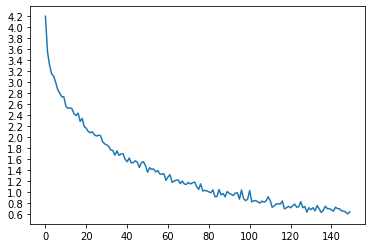

input:  i m a beginner too . <EOS>
target: moi aussi je suis debutant . <EOS>
output: je suis egalement moi . <EOS>


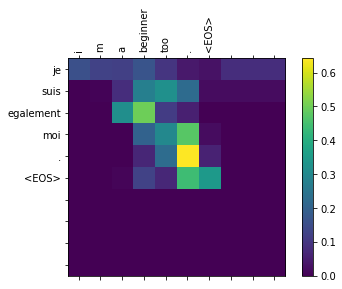

input:  you re the teacher . <EOS>
target: c est vous l enseignant . <EOS>
output: vous etes l instituteur . <EOS>


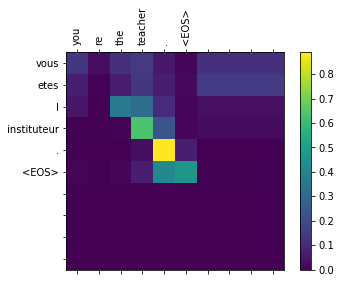

input:  you re right i think . <EOS>
target: je pense que vous avez raison . <EOS>
output: tu as raison que tu as raison . <EOS>


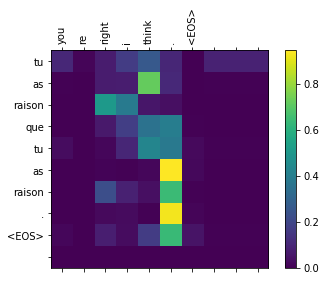

input:  i m happy enough . <EOS>
target: je suis assez contente . <EOS>
output: je suis assez heureuse . <EOS>


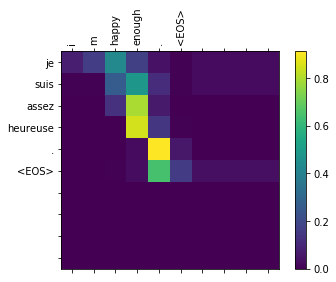

input:  we re not friends anymore . <EOS>
target: nous ne sommes plus amis . <EOS>
output: nous ne sommes plus amis . <EOS>


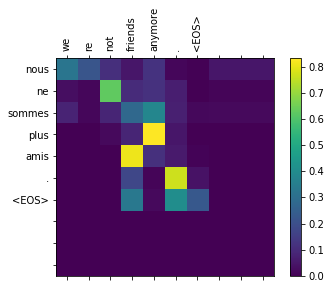

In [23]:
import torch

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Prepares for data.
    SOS_token = 0
    EOS_token = 1
        
    input_lang, output_lang, pairs = prepare_data(lang1="eng", lang2="fra")
    
    # Model.
    embed_size = 300
    hidden_size = 256
    
    encoder = Encoder(input_lang.n_words, hidden_size, embed_size).to(device)  # device
    decoder = Decoder(output_lang.n_words, hidden_size, embed_size).to(device)  # device
    
    # Training.
    train(encoder, decoder, pairs, input_lang, output_lang)
    
    # Evaluating.
    evaluate(encoder, decoder, pairs, input_lang, output_lang)